<a href="https://colab.research.google.com/github/Jevaan21/intrusion-detection-dl/blob/main/intrusion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
!pip install tensorflow

In [31]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models

Load Data

In [32]:
!wget https://raw.githubusercontent.com/Jevaan21/intrusion-detection-dl/refs/heads/main/KDDTrain%2B.csv

--2025-07-22 12:52:39--  https://raw.githubusercontent.com/Jevaan21/intrusion-detection-dl/refs/heads/main/KDDTrain%2B.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14612857 (14M) [text/plain]
Saving to: ‘KDDTrain+.csv.1’

KDDTrain+.csv.1     100%[===================>]  13.94M  --.-KB/s    in 0.1s    

2025-07-22 12:52:39 (106 MB/s) - ‘KDDTrain+.csv.1’ saved [14612857/14612857]



In [33]:
!ls


KDDTrain+.csv  KDDTrain+.csv.1	sample_data


In [34]:
import pandas as pd

# Define all 43 columns
column_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate",
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate", "label", "difficulty_level"
]

# Load the file that exists in the same directory
df = pd.read_csv("KDDTrain+.csv", names=column_names)

# Drop the metadata column
df.drop("difficulty_level", axis=1, inplace=True)

# Show sample
df.head()


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


Label encode categorical columns

In [35]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

df_encoded = df.copy()

In [36]:
label_encoders = {}
categorical_cols = ['protocol_type', 'service', 'flag', 'label']

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le  # Save for inverse transform later

Normalize numerical features (excluding label)

In [37]:
scaler = StandardScaler()
X = df_encoded.drop("label", axis=1)
X_scaled = scaler.fit_transform(X)

Prepare target

In [38]:
# Binary label: 0 = normal, 1 = attack
df_encoded['label_binary'] = df_encoded['label'].apply(lambda x: 0 if x == label_encoders['label'].transform(['normal'])[0] else 1)
y = df_encoded['label_binary'].values


Split into train/test

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

In [40]:
print("Preprocessing complete. Shape:", X_train.shape, X_test.shape)

Preprocessing complete. Shape: (100778, 41) (25195, 41)


In [41]:
import tensorflow as tf
from tensorflow.keras import layers, models

 Define the custom Attention layer

In [42]:
class Attention(tf.keras.layers.Layer):
    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super().build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

Build the model

In [43]:
model = models.Sequential([
    layers.Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)),

    layers.Conv1D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),
    layers.BatchNormalization(),

    layers.Conv1D(128, 5, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),
    layers.BatchNormalization(),

    layers.LSTM(64, return_sequences=True),
    Attention(),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
   layers.Dense(1, activation='sigmoid')

])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 Compile the model

In [44]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


#Summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 41, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 41, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 20, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_1 (Attention)         │ (None, 64)             │            74 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,819 (374.29 KB)

 Trainable params: 95,435 (372.79 KB)

 Non-trainable params: 384 (1.50 KB)

 Train the Model

In [45]:
history = model.fit(
    X_train, y_train,
    epochs=5,             #  Reduce to 5 epochs
    batch_size=270,       #  Increase batch size to speed up
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/5
374/374 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step - accuracy: 0.9547 - loss: 0.1378 - val_accuracy: 0.9694 - val_loss: 0.0756
Epoch 2/5
374/374 ━━━━━━━━━━━━━━━━━━━━ 41s 107ms/step - accuracy: 0.9900 - loss: 0.0288 - val_accuracy: 0.9924 - val_loss: 0.0225
Epoch 3/5
374/374 ━━━━━━━━━━━━━━━━━━━━ 39s 103ms/step - accuracy: 0.9923 - loss: 0.0230 - val_accuracy: 0.9936 - val_loss: 0.0190
Epoch 4/5
374/374 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - accuracy: 0.9944 - loss: 0.0171 - val_accuracy: 0.9907 - val_loss: 0.0266
Epoch 5/5
374/374 ━━━━━━━━━━━━━━━━━━━━ 40s 102ms/step - accuracy: 0.9937 - loss: 0.0189 - val_accuracy: 0.9946 - val_loss: 0.0151


Evaluation Metrics

788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step


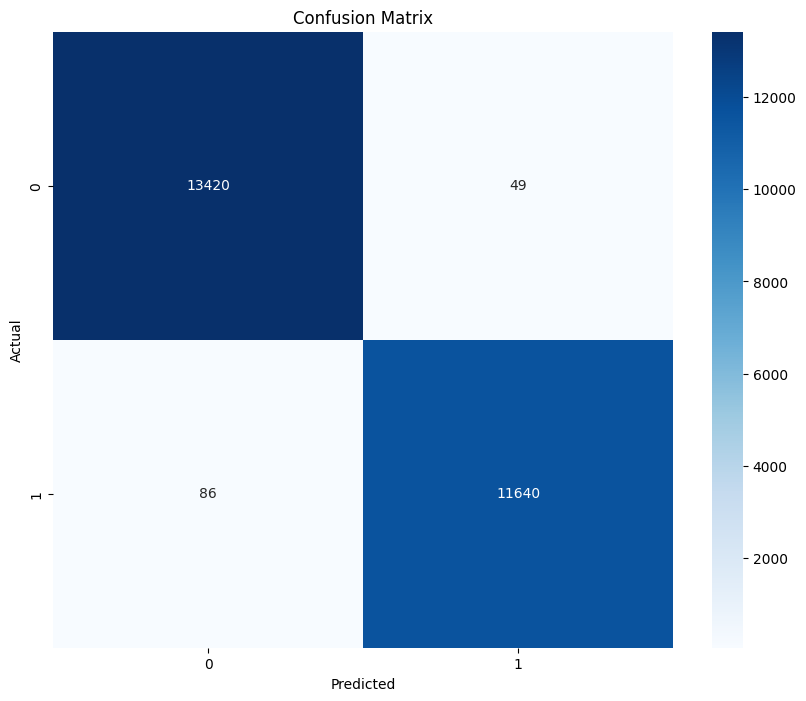

              precision    recall  f1-score   support

           0     0.9936    0.9964    0.9950     13469
           1     0.9958    0.9927    0.9942     11726

    accuracy                         0.9946     25195
   macro avg     0.9947    0.9945    0.9946     25195
weighted avg     0.9946    0.9946    0.9946     25195



In [46]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, digits=4))

Calculate Macro F1 Only

In [47]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred, average='macro')
print(f"🎯 Macro F1 Score: {f1:.4f}")

🎯 Macro F1 Score: 0.9946


In [48]:
print(f"✅ Achieved F1 = {f1:.4f}, target met.")


✅ Achieved F1 = 0.9946, target met.
